# Filament Detection

The current ETP has the capability of detecting filament diameter in real time from images. While it can work for certain images, the "two line" method is less robust and might not be very optimized in terms of computational power. Moreover, the method is embedded in Labview, therefore prevents further development. These considerations lead to the need of developing a new filament detection algorithm, which is potentially faster, more robust, and opens up possibilities for improvement. This new algorithm will be based on `opencv`. This notebook is the V0 of the algorithm.

## 0 Packages

In [11]:
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from myimagelib import to8bit
import glob
from skan import Skeleton, summarize
from skimage import filters

## 1 Preprocessing

- read image
- blur
- binarize

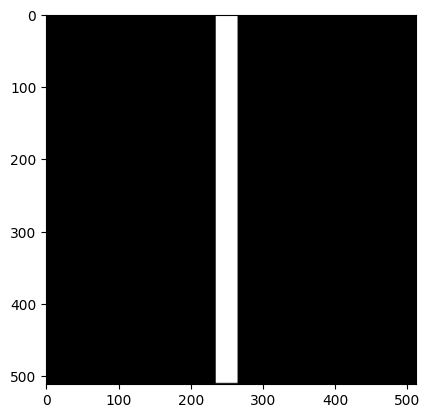

In [2]:
folder = Path("../test/filament_images_simulated")
img = cv2.imread(folder / "upright_30px.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap="gray")

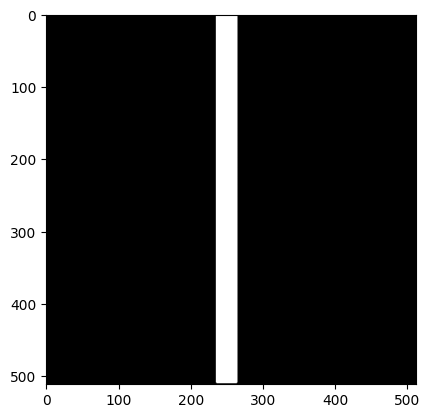

In [3]:
blur = cv2.GaussianBlur(img, (5, 5), 0)
_, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(binary, cmap="gray")

## 2 Distance transform and skeletonization

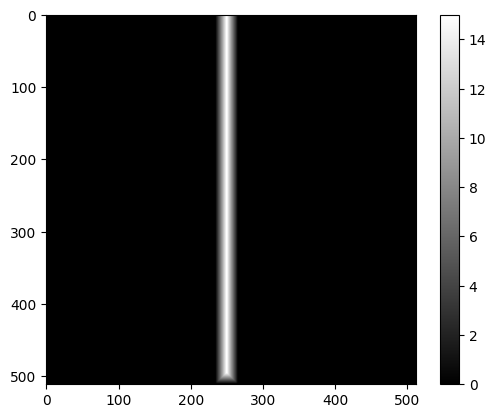

In [8]:
dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
plt.imshow(dist_transform, cmap="gray")
plt.colorbar()

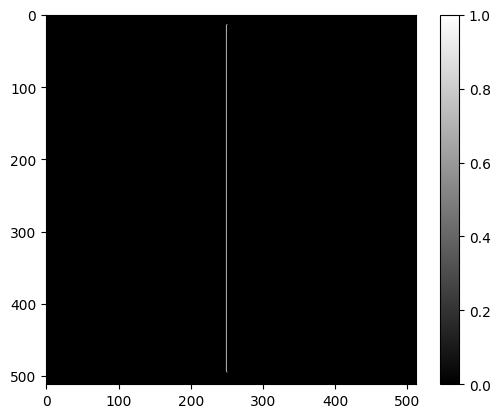

In [9]:
skeleton = skeletonize(binary)
plt.imshow(skeleton, cmap="gray")
plt.colorbar()

## 3 Calculated the diameter

The distance transform is just the distance from any point in the foreground region to the closest background region. So the diameter would be twice of the DT value on the skeleton

In [14]:
diameter = dist_transform[skeleton].mean() * 2
print(f"Diameter: {diameter:.1f} px")

Diameter: 30.0 px


This is exactly what we drew.

## 4 Put steps together

In [42]:
def filament_diameter(img):
    """Calculate the diameter of a filament in an image. 
    The filament is assumed to be brighter than the background.
    The method uses distance transform and skeletonization to estimate the diameter.
    
    Parameters:
    -----------
    img : np.ndarray
        Input image containing the filament.
        
    Returns:
    --------
    diameter: float
        Estimated diameter of the filament in pixels.
    skeleton: np.ndarray
        Binary image of the filament skeleton. For visualization purpose.
    """
    assert img.ndim == 2, "Input image must be grayscale"

    img = to8bit(img) # convert to 8-bit if necessary, maximaize the contrast

    blur = cv2.GaussianBlur(img, (5, 5), 0)

    thresh = filters.threshold_otsu(img)
    print(thresh)
    _, binary = cv2.threshold(blur, thresh, 255, cv2.THRESH_BINARY)

    dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)

    skeleton = skeletonize(binary)

    diameter = dist_transform[skeleton].mean() * 2

    return diameter, skeleton, dist_transform

In [32]:
img_list = glob.glob(str(folder / "*.png"))

In [33]:
for img_url in img_list:
    img = cv2.imread(img_url, cv2.IMREAD_GRAYSCALE)
    diameter, skeleton = filament_diameter(img)
    print(f"Diameter of {img_url}: {diameter:.1f} px")

Diameter of ../test/filament_images_simulated/tilted_30px.png: 29.4 px
Diameter of ../test/filament_images_simulated/curly_50px.png: 48.8 px
Diameter of ../test/filament_images_simulated/curly_30px.png: 30.1 px
Diameter of ../test/filament_images_simulated/upright_50px.png: 50.0 px
Diameter of ../test/filament_images_simulated/upright_30px.png: 30.0 px
Diameter of ../test/filament_images_simulated/tilted_50px.png: 47.1 px


The accuracy turns out to be pretty good.

## 5 Visualize the filament detection result

In [18]:
def draw_filament_contour(img, skeleton, diameter):
    """Draw the contour of the filament based on its skeleton and diameter.
    
    Parameters:
    -----------
    img : np.ndarray
        Input image containing the filament.
    skeleton: np.ndarray
        Binary image of the filament skeleton.
    diameter: float
        Estimated diameter of the filament in pixels.
        
    Returns:
    --------
    contour_img: np.ndarray
        Image with the filament contour drawn.
    """
    reconstructed_mask = np.zeros_like(img, dtype=np.uint8)
    
    # Find coordinates of skeleton points
    y_coords, x_coords = np.where(skeleton)
    
    for (x, y) in zip(x_coords, y_coords):
        center = (x, y) # OpenCV坐标是(x, y)
        
        # 绘制白色的实心圆 (颜色255, thickness=-1表示填充)
        cv2.circle(reconstructed_mask, center, int(round(diameter//2)), 255, thickness=-1)

    contours, _ = cv2.findContours(reconstructed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    img_rgb = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), cv2.COLOR_BGR2RGB)

    labeled_image = cv2.drawContours(img_rgb.copy(), contours, -1, (255, 0, 0), 2)

    return labeled_image

In [44]:
labeled = draw_filament_contour(img, skeleton, diameter)

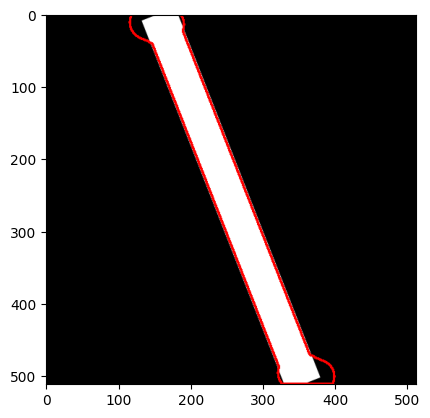

In [45]:
plt.imshow(labeled)

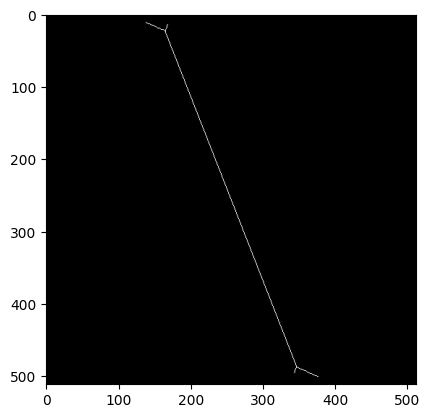

In [46]:
plt.imshow(skeleton, cmap="gray")

## 6 Trim branches

The visualization above indicates that imperfections in the image can result in branches in the skeleton, which makes the diameter detection less accurate. To improve this, we can analyze the skeleton and remove small branches before we finally compute the diameter. 

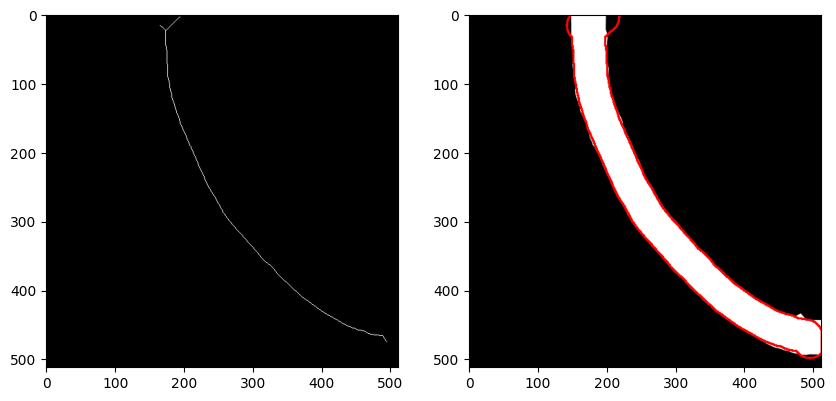

In [55]:
img = cv2.imread(folder / "curly_50px.png", cv2.IMREAD_GRAYSCALE)
diameter, skeleton = filament_diameter(img)
labeled = draw_filament_contour(img, skeleton, diameter)
fig, ax = plt.subplots(ncols=2, figsize=(10, 5), dpi=100)
ax[0].imshow(skeleton, cmap="gray")
ax[1].imshow(labeled)

In [60]:
skel_obj = Skeleton(skeleton)
branch_data = summarize(skel_obj)

/tmp/ipykernel_9744/3332208110.py:2: VisibleDeprecationWarning: separator in column name will change to _ in version 0.13; to silence this warning, use `separator='-'` to maintain current behavior and use `separator='_'` to switch to the new default behavior.
  branch_data = summarize(skel_obj)


In [72]:
branch_data

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
0,0,1,28,28.870058,1,1.0,0.0,4,194,23,173,4,194,23,173,28.319605
1,0,13,28,10.899495,1,1.0,0.0,16,165,23,173,16,165,23,173,10.630146
2,0,28,546,623.038672,1,1.0,0.0,23,173,475,494,23,173,475,494,554.387049


In [ ]:
# select the longest branch
long_branch_id = branch_data["branch-distance"].argmax() + 1

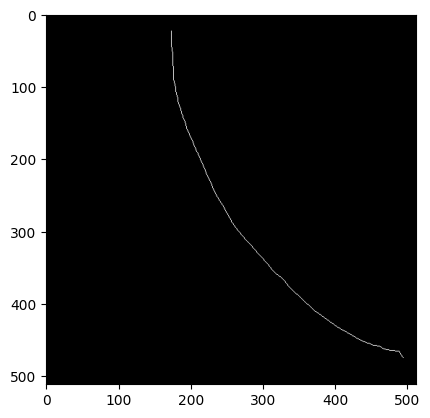

In [89]:
branch_labels = skel_obj.path_label_image()
trimmed_skeleton = branch_labels == long_branch_id
plt.imshow(trimmed_skeleton, cmap='gray')

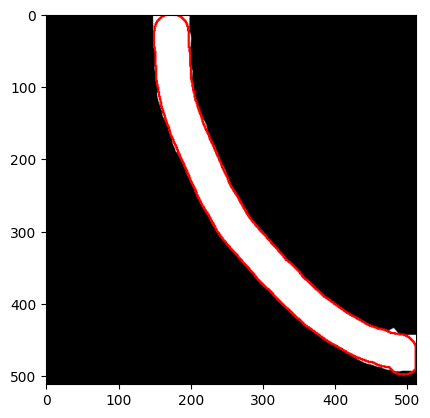

In [88]:
labeled = draw_filament_contour(img, trimmed_skeleton, diameter)
plt.imshow(labeled)

In [47]:
def find_longest_branch(skeleton):
    """Find the longest branch in a skeleton image (binary).
    If no skeleton is present, return the original image.
    
    Parameters
    ----------
    skeleton : nd.array
        skeleton image
    
    Returns
    -------
    nd.array
        the longest branch label image
    """
    try:
        skel_obj = Skeleton(skeleton)
    except ValueError as e:
        print(f"ValueError: {e}")
        return skeleton
    
    branch_data = summarize(skel_obj) # analyze the branches in the skeleton

    long_branch_id = branch_data["branch-distance"].argmax() + 1 # find the id of the longest branch (it's the data index + 1)

    branch_labels = skel_obj.path_label_image() # get path label image where locations of skeleton are labeled

    longest_branch = (branch_labels == long_branch_id) # find where label == the id

    return longest_branch

/tmp/ipykernel_9744/2841703785.py:21: VisibleDeprecationWarning: separator in column name will change to _ in version 0.13; to silence this warning, use `separator='-'` to maintain current behavior and use `separator='_'` to switch to the new default behavior.
  branch_data = summarize(skel_obj) # analyze the branches in the skeleton


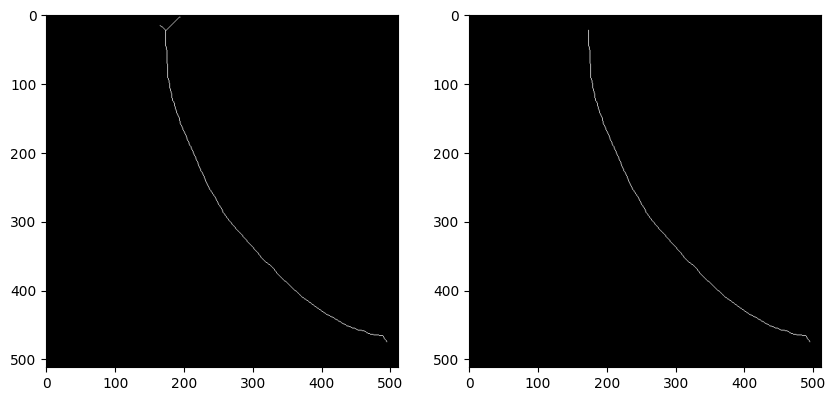

In [103]:
img = cv2.imread(folder / "curly_50px.png", cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
skeleton = skeletonize(binary)
longest_branch = find_longest_branch(skeleton)
fig, ax = plt.subplots(ncols=2, figsize=(10, 5), dpi=100)
ax[0].imshow(skeleton, cmap="gray")
ax[1].imshow(longest_branch, cmap="gray")

## 7 Two step method

We notice that the orginal diameter was obtained by averaging the diameter over the whole skeleton. The analysis above, however, showed that only certain part (longest branch) of the skeleton gives the most accurate diameter of the filament. In other words, the original diameter includes some edge noise, which can be removed by a two-step approach: find the longest branch, then select only the diameter on it to average. 

This section implement this approach. 

Rough estimate: 48.774017333984375 px
Refined: 49.6800537109375


/tmp/ipykernel_9744/2841703785.py:21: VisibleDeprecationWarning: separator in column name will change to _ in version 0.13; to silence this warning, use `separator='-'` to maintain current behavior and use `separator='_'` to switch to the new default behavior.
  branch_data = summarize(skel_obj) # analyze the branches in the skeleton


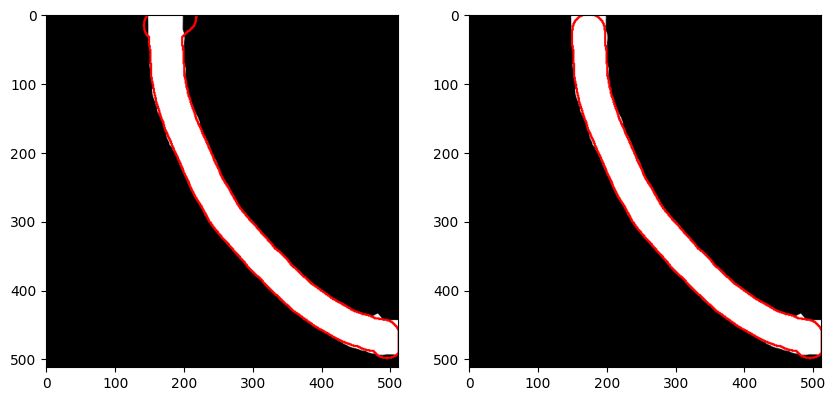

In [106]:
img = cv2.imread(folder / "curly_50px.png", cv2.IMREAD_GRAYSCALE)
diameter, skeleton, dist_transform = filament_diameter(img) # the rough estimate
print(f"Rough estimate: {diameter} px")
longest_branch = find_longest_branch(skeleton)
diameter_refine = dist_transform[longest_branch].mean() * 2.0
print(f"Refined: {diameter_refine}")

fig, ax = plt.subplots(ncols=2, figsize=(10, 5), dpi=100)
label_rough = draw_filament_contour(img, skeleton, diameter)
label_refine = draw_filament_contour(img, longest_branch, diameter_refine)
ax[0].imshow(label_rough)
ax[1].imshow(label_refine)

As can be seen, the detected diameter is much closer to the ground truth, and the contour gets much smoother and aligned with the filament in the raw image. 

# Appendix



## A. Handle exceptions

To make the algorithm more robust, we can include known exceptions to the code in the development phase, so that they can be handled elegently. 

### A1. No filament detected

One such exception is when the image is completely dark and no skeleton can be detected. 

In [117]:
img = cv2.imread(folder / "black.png", cv2.IMREAD_GRAYSCALE)
blur = cv2.GaussianBlur(img, (5, 5), 0)
_, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

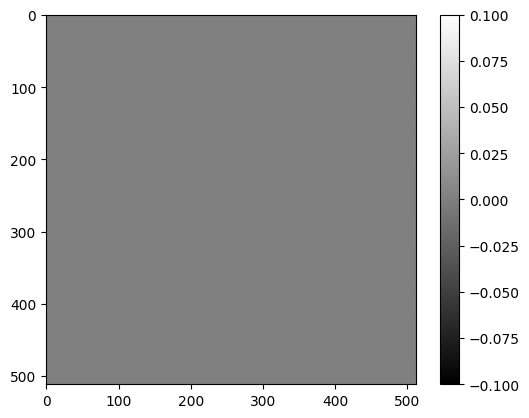

In [118]:
dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
plt.imshow(dist_transform, cmap="gray")
plt.colorbar()

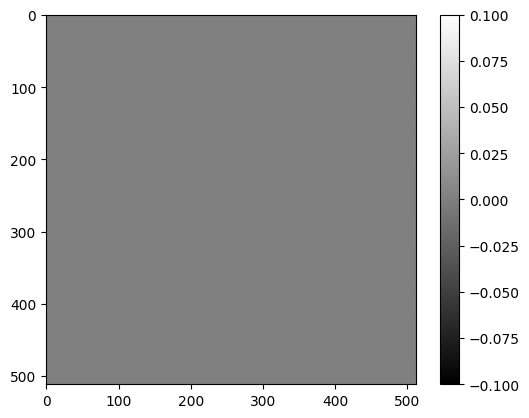

In [119]:
skeleton = skeletonize(binary)
plt.imshow(skeleton, cmap="gray")
plt.colorbar()

In [93]:
diameter = dist_transform[skeleton].mean() * 2
print(f"Diameter: {diameter:.1f} px")

Diameter: nan px


/tmp/ipykernel_9744/4069308696.py:1: RuntimeWarning: Mean of empty slice.
  diameter = dist_transform[skeleton].mean() * 2
/home/zhengyang/miniconda3/envs/py12/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [96]:
diameter, skeleton = filament_diameter(img)

/home/zhengyang/miniconda3/envs/py12/lib/python3.12/site-packages/myimagelib/myImageLib.py:124: RuntimeWarning: invalid value encountered in divide
  img8 = (img - minn) / (maxx - minn) * 255
/home/zhengyang/miniconda3/envs/py12/lib/python3.12/site-packages/myimagelib/myImageLib.py:125: RuntimeWarning: invalid value encountered in cast
  return img8.astype('uint8')
/tmp/ipykernel_9744/2369568389.py:30: RuntimeWarning: Mean of empty slice.
  diameter = dist_transform[skeleton].mean() * 2
/home/zhengyang/miniconda3/envs/py12/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


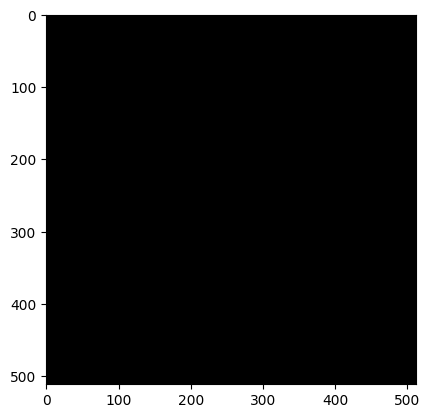

In [98]:
labeled = draw_filament_contour(img, skeleton, diameter)
plt.imshow(labeled)

In [99]:
skel_obj = Skeleton(skeleton)
branch_data = summarize(skel_obj)
# select the longest branch
long_branch_id = branch_data["branch-distance"].argmax() + 1

ValueError: index pointer size 0 should be 1

In [121]:
longest_branch = find_longest_branch(skeleton)

ValueError: index pointer size 0 should be 1


In [124]:
longest_branch

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(512, 512))

So, the first exception we are going to handle is the ValueError at `Skeleton(skeleton)`, which means no skeleton is present in the provided skeleton image. This will abort the process of finding the longest skeleton, and hand in the original skeleton image to the diameter finder and contour finder. 

In [107]:
def convert_to_grayscale(img):
    """
    Converts an image to grayscale.

    Parameters
    ----------
    img : np.ndarray
        Either a string representing the path to an image file, or a numpy array (OpenCV image).

    Returns
    -------
    np.ndarray
        A numpy array representing the grayscale image, or None if conversion fails.
    """

    # Check if the image already has only 2 dimensions (meaning it's already grayscale)
    # or if it has 3 channels (most common color image format)
    if len(img.shape) == 2:
        print("Image is already grayscale.")
        return img # It's already grayscale, no conversion needed

    if len(img.shape) == 3:
        # Check the number of channels to determine the correct conversion code
        # Most common: BGR (3 channels) or BGRA (4 channels with alpha)
        channels = img.shape[2]
        if channels == 3:
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        elif channels == 4:
            # If it has an alpha channel, convert from BGRA to GRAY
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
        else:
            print(f"Warning: Image has {channels} channels, which is unusual for a color image. Attempting BGR to GRAY.")
            # Fallback, might not be accurate if the channel order is non-standard
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    else:
        print(f"Error: Unsupported image shape: {img.shape}. Cannot convert to grayscale.")
        return None
        
    return gray_img

In [109]:
folder = Path("/home/zhengyang/Documents/GitHub/etp_ctl/test/filament_images_simulated")
img = cv2.imread(folder / "curly_50px.png")

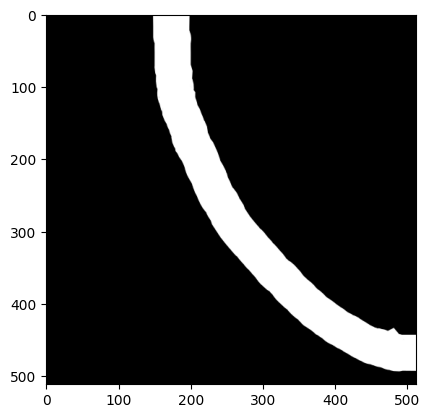

In [110]:
plt.imshow(img)

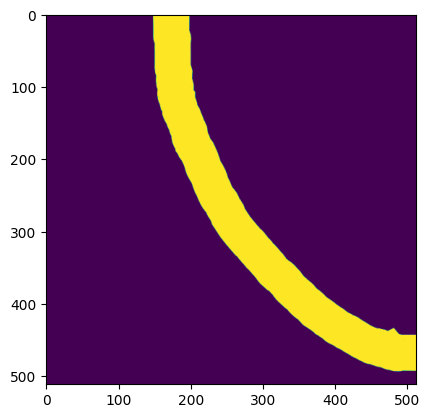

In [111]:
cvt = convert_to_grayscale(img)
plt.imshow(cvt)

In [115]:
diameter, skeleton, dist_transform = filament_diameter(cvt)
longest_branch = find_longest_branch(skeleton)
diameter_refine = dist_transform[longest_branch].mean() * 2.0
proc_frame = draw_filament_contour(cvt, longest_branch, diameter_refine)

/tmp/ipykernel_9744/2841703785.py:21: VisibleDeprecationWarning: separator in column name will change to _ in version 0.13; to silence this warning, use `separator='-'` to maintain current behavior and use `separator='_'` to switch to the new default behavior.
  branch_data = summarize(skel_obj) # analyze the branches in the skeleton


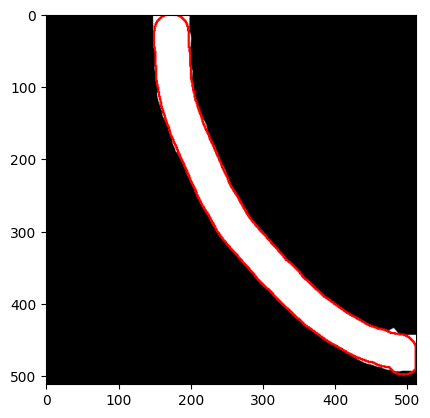

In [116]:
plt.imshow(proc_frame)

## B. Detection is a litter off

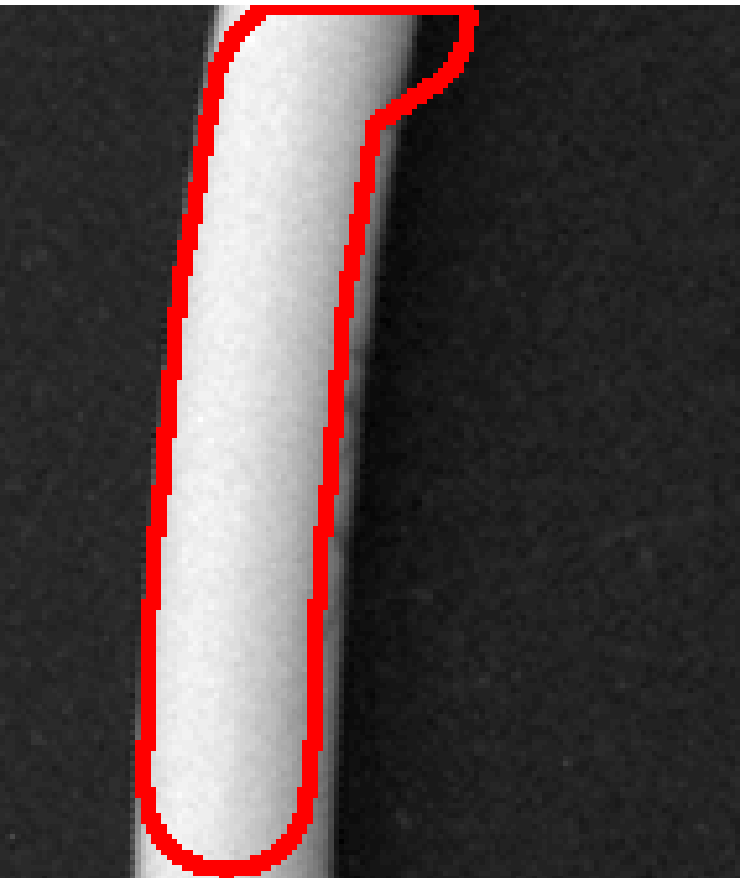

In [20]:
import sys 
sys.path.append("../src")
from vision import filament_diameter, find_longest_branch, draw_filament_contour, binarize

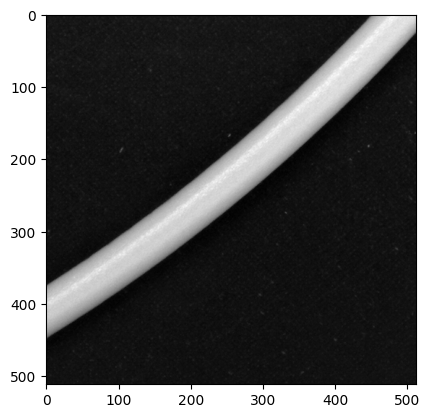

In [12]:
folder = Path("~/Documents/GitHub/HEPiC/test/filament_images_captured").expanduser()
img = cv2.imread(folder / "Image_20251023140119217.bmp", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap="gray")

Rough estimate: 55.850730895996094 px
Refined: nan


/var/folders/nm/bcg_73957lldftrq5th8yd6m0000gn/T/ipykernel_59590/383601255.py:7: RuntimeWarning: Mean of empty slice.
  diameter_refine = dist_transform[longest_branch].mean() * 2.0
/Users/zhengyang/miniconda3/envs/py12/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


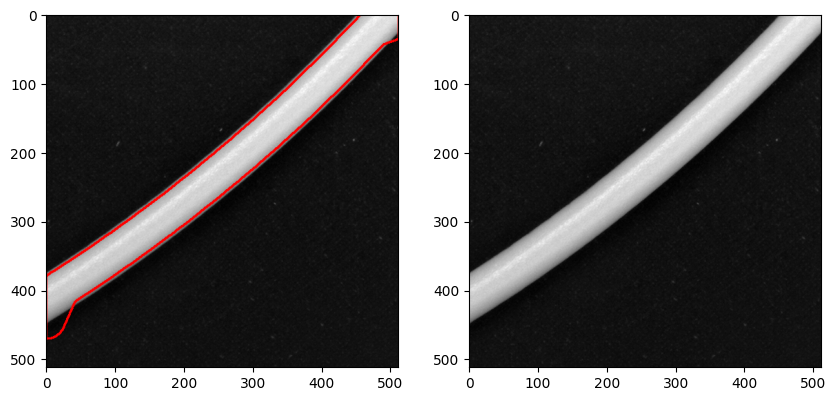

In [30]:
binary = binarize(img)
diameter, skeleton, dist_transform = filament_diameter(binary) # the rough estimate
print(f"Rough estimate: {diameter} px")
longest_branch = find_longest_branch(skeleton)
# filter the pixels on skeleton where dt is smaller than 0.9 of the max
longest_branch[dist_transform < dist_transform.max()*0.95] = False
diameter_refine = dist_transform[longest_branch].mean() * 2.0
print(f"Refined: {diameter_refine}")

fig, ax = plt.subplots(ncols=2, figsize=(10, 5), dpi=100)
label_rough = draw_filament_contour(img, skeleton, diameter)
label_refine = draw_filament_contour(img, longest_branch, diameter_refine)
ax[0].imshow(label_rough)
ax[1].imshow(label_refine)

Text(0, 0.5, 'count')

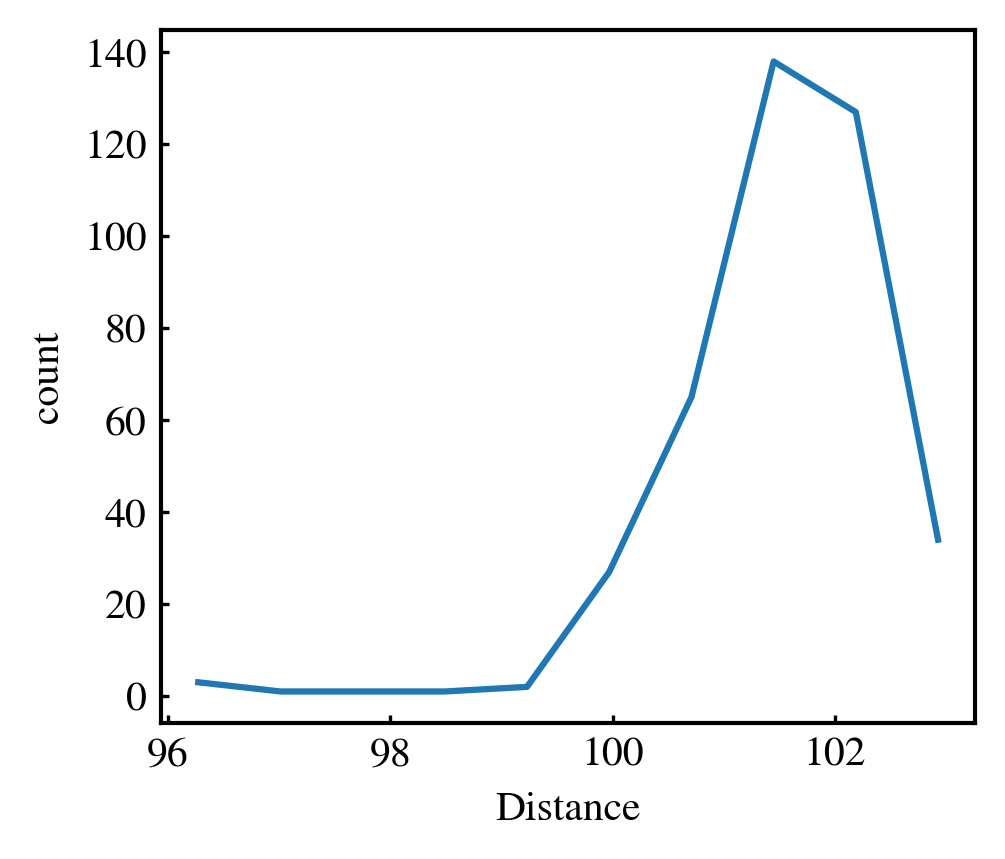

In [54]:
hist, bin_edges = np.histogram(dist_transform[longest_branch])
plt.plot(bin_edges[:-1], hist)
plt.xlabel("Distance")
plt.ylabel("count")

In [35]:
binary = binarize(img)
diameter, skeleton, dist_transform = filament_diameter(binary)

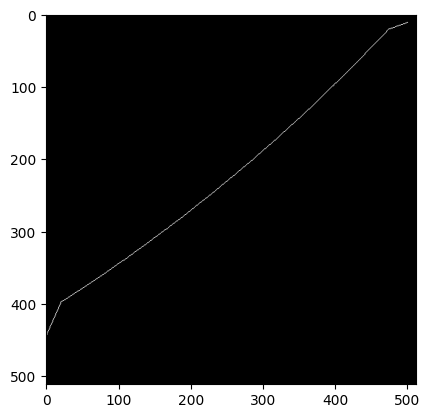

In [36]:
plt.imshow(skeleton, cmap="gray")

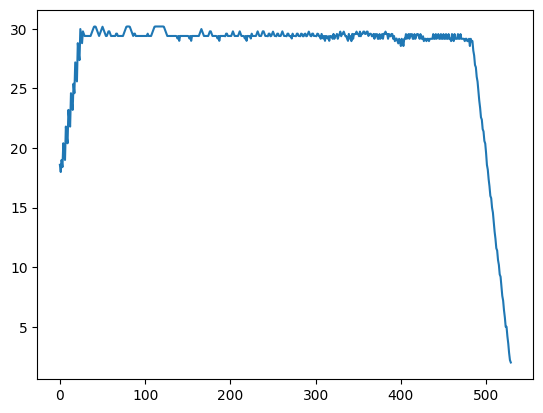

In [37]:
skel_px = dist_transform[skeleton]
plt.plot(skel_px)

In [38]:
skel_px.mean()

np.float32(27.925365)

This seems to be a universal pattern: most of the distances are correct measure, but close to the edge, there are outliers. We can use the mean of the skeleton dist transform as the cutoff to remove the extremely small values near edges. 

In [39]:
skeleton_refine = skeleton.copy()
skeleton_refine[dist_transform < skel_px.mean()] = False

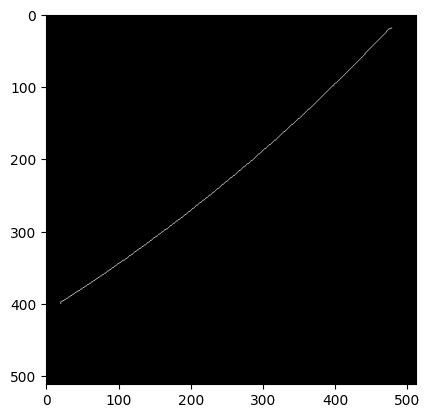

In [42]:
plt.imshow(skeleton_refine, cmap="gray")

In [43]:
diameter_refine = dist_transform[skeleton_refine].mean() * 2.0
diameter_refine

np.float32(58.88476)

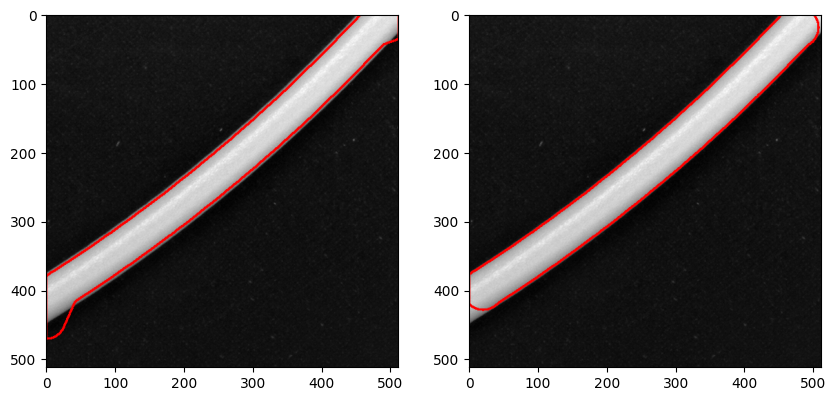

In [45]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5), dpi=100)
label_rough = draw_filament_contour(img, skeleton, diameter)
label_refine = draw_filament_contour(img, skeleton_refine, diameter_refine)
ax[0].imshow(label_rough)
ax[1].imshow(label_refine)

In [48]:
import glob
l = glob.glob(str(folder / "*.bmp"))

In [53]:
skel_px.std()

np.float32(13.30917)

In [54]:
skel_px.mean()

np.float32(19.953259)

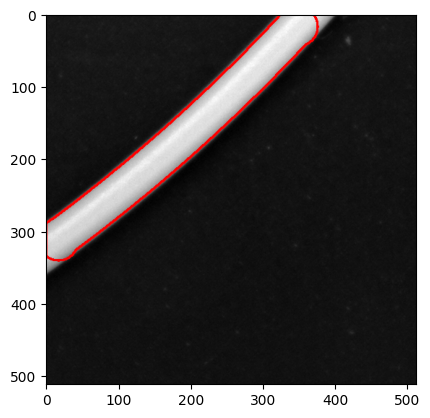

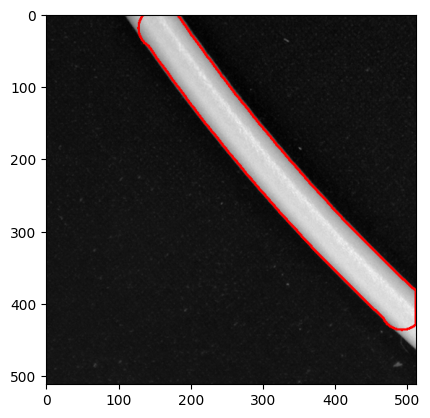

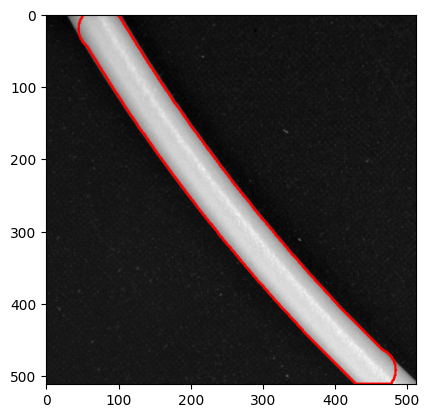

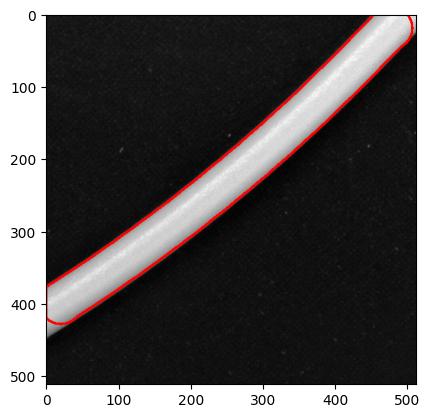

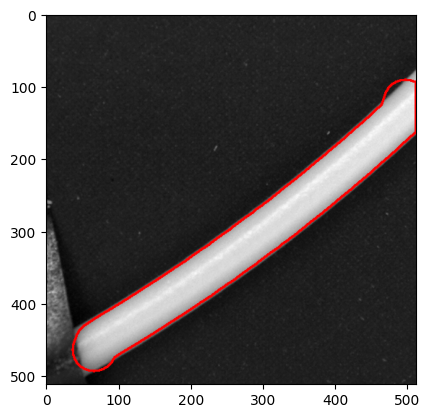

In [59]:
for f in l:
    img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    binary = binarize(img)
    diameter, skeleton, dist_transform = filament_diameter(binary) # the rough estimate
    skel_px = dist_transform[skeleton]
    skeleton_refine = skeleton.copy()
    skeleton_refine[dist_transform < skel_px.mean()] = False
    diameter_refine = dist_transform[skeleton_refine].mean() * 2.0
    label_refine = draw_filament_contour(img, skeleton_refine, diameter_refine)
    plt.figure()
    plt.imshow(label_refine)